# Convolutional Neural Network

Convolutional Neural Networks (CNNs) are a specialized type of deep neural network designed to process data with a grid-like topology, such as images. Unlike traditional neural networks, which treat input data as a flat array, CNNs apply some filters to the image that let the network better extract features by using kernels learnt at training time.

![Convolution diagram](https://editor.analyticsvidhya.com/uploads/94787Convolutional-Neural-Network.jpeg)

## Key Components
The key components of CNNs—convolutional layers, pooling layers, and fully connected layers—work together to extract and distill these features.
1. **Convolutional Layers**: in convolutional layers the algorithm applies filters to the image, trying to extract relevant features of it. Each filter in a convolutional layer is essentially a small matrix that is convolved across the image.
2. **Pooling Layers**: After detecting features, we want to reduce the dimensionality of the data while retaining the most important information.
Pooling layers downsample the feature maps through operations like MaxPooling or AveragePooling, providing a smaller matrix at the end of the process.
3. **Fully Connected Layers**: After extracting features we need to use what we discovered through layers to get to a final conclusion and maybe we want to assign a label to the image. We need some fully connected layers to predict the probability distribution across the possible classes.

### Padding
When we apply convolution to a $n\times n$ image with a $f\times f$ filter, the result will be a $n - f + 1 \times n - f + 1$ matrix.
In case we need to keep the dimensions and not shrink the output we need to apply some padding.
In case of padding we are using a **same convolution** because it keeps the same dimensions. Otherwise we call it **valid convolution**.

### Stride
Another parameter we need to take care of when performing convolutions is the stride. It tells us how much we move right and down when we move with a filter on the image. Tweaking this parameter the output will change in dimension following this formula:
$$\bigg\lfloor \frac{n + 2p-f}{s}+1 \bigg\rfloor \times \bigg\lfloor \frac{n + 2p-f}{s}+1 \bigg\rfloor \times n_f$$
where $n_f$ is the number of filters we apply to the image.

![Pooling](https://media.geeksforgeeks.org/wp-content/uploads/20190721025744/Screenshot-2019-07-21-at-2.57.13-AM.png)

## Why Convolutions?
The two main advantages are **parameters sharing** and **sparsity of connections**.
- **Parameters sharing**: A feature detector (vertical edge detector, ...) that's useful in one part of the image is probably **useful in another part** of the image.
- **Sparsity of connections**: In each layer, each output value depends only on a **small number of inputs**. It means that each cell is not computed based on the entire matrix, but starting from a part of it.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, ReLU, MaxPool2D
from tensorflow.keras import Input
from tensorflow.keras.optimizers import Adam
from tensorflow import cast, float32
from tensorflow.data.experimental import AUTOTUNE
from tensorflow.keras.callbacks import Callback

%matplotlib inline

# Dataset
I am using a standard dataset provided by `tensorflow_datasets`, the **MNIST Digits** dataset.
It is a collection of (28x28x1) hand-written digits.

![MNIST dataset](https://upload.wikimedia.org/wikipedia/commons/f/f7/MnistExamplesModified.png)

https://huggingface.co/datasets/ylecun/mnist.

In [ ]:
(ds_train, ds_test), ds_info = tfds.load(
    'mnist',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [ ]:
def normalize_img(image, label):
    return cast(image, float32) / 255.0, label

In [ ]:
bs = 32         # batch size
lr = 0.001      # learning rate
epochs = 100

In [ ]:
ds_train = ds_train.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_train = ds_train.cache()
ds_train = ds_train.shuffle(ds_info.splits['train'].num_examples)
ds_train = ds_train.batch(bs)
ds_train = ds_train.prefetch(AUTOTUNE)

ds_test = ds_test.map(normalize_img, num_parallel_calls=AUTOTUNE)
ds_test = ds_test.batch(bs)
ds_test = ds_test.cache()
ds_test = ds_test.prefetch(AUTOTUNE)

## Callback
I introduced a callback function in order to early stop the training based on the accuracy reached through epochs. It is a concept I have learnt during the [TensorFlow Developer Professional Certificate](https://www.coursera.org/professional-certificates/tensorflow-in-practice?) Specialization on Coursera, offered by [DeepLearning.AI](https://www.deeplearning.ai/).

In [ ]:
class myCallback(Callback):
  def on_epoch_end(self, epoch, logs={}):
    if (logs.get('accuracy') > 0.99):
      print('\nAccuracy Reached!')
      self.model.stop_training = True

In [ ]:
callbacks = myCallback()

# Model
Here I am defining the model, by stacking layers in the Sequential class.

- `Input` layer: it defines the size of the input. In this case we expect `(28,28,1)` images.
- `Conv2D` layers: These layers apply convolutional filters of different sizes to the input image. The `padding='same'` ensures that the output image has the same size as the input by adding padding where necessary.
- `ReLU` layers: The Rectified Linear Unit (ReLU) activation function is applied to introduce non-linearity into the model, allowing it to learn more complex patterns.
- `MaxPool2D` layers: These layers perform max pooling. It reduces the spatial dimensions of the image, keeping the most important features. The `padding='same'` ensures that the output dimensions remain consistent.
- `Flatten` layer: Once we have finished with convolutions we need to flat data into a 1D vector.
- `Dense` layer: It has 10 units, each corresponding to one of the 10 digit classes (0-9). The `softmax` activation function outputs a probability distribution over the classes, with the highest probability indicating the model's predicted class.

In [ ]:
# Define the model
model = Sequential([
    Input(shape=(28, 28, 1)),
    Conv2D(filters=8, kernel_size=(4, 4), strides=(1, 1), padding='same'),
    ReLU(),
    MaxPool2D(pool_size=(8, 8), strides=(8, 8), padding='same'),
    Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), padding='same'),
    ReLU(),
    MaxPool2D(pool_size=(4, 4), strides=(4, 4), padding='same'),
    Flatten(),
    Dense(units=10, activation='softmax')
])

# Define the optimizer
opt = Adam(learning_rate=lr)

# Compile the model
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(x=ds_train, validation_data=ds_test, epochs=epochs, callbacks=[callbacks])

Epoch 1/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 26s 13ms/step - accuracy: 0.5090 - loss: 1.4855 - val_accuracy: 0.8632 - val_loss: 0.4728
Epoch 2/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.8677 - loss: 0.4315 - val_accuracy: 0.8982 - val_loss: 0.3215
Epoch 3/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9007 - loss: 0.3249 - val_accuracy: 0.9167 - val_loss: 0.2605
Epoch 4/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 41s 13ms/step - accuracy: 0.9144 - loss: 0.2733 - val_accuracy: 0.9248 - val_loss: 0.2343
Epoch 5/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9236 - loss: 0.2390 - val_accuracy: 0.9256 - val_loss: 0.2264
Epoch 6/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9312 - loss: 0.2212 - val_accuracy: 0.9343 - val_loss: 0.1951
Epoch 7/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 25s 13ms/step - accuracy: 0.9367 - loss: 0.1985 - val_accuracy: 0.9366 - val_loss: 0.1908
Epoch 8/100
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 24s 13ms/step - accuracy: 

# Results
Training and validation curves show that the model is performing well:

- **Accuracy**: Both training and validation accuracy rapidly improve and stabilize around 95-96%, indicating that the model is learning effectively and generalizes well.

- **Loss**: Training and validation loss decrease steadily, converging without divergence, which doesn't suggest an overfitting problem.

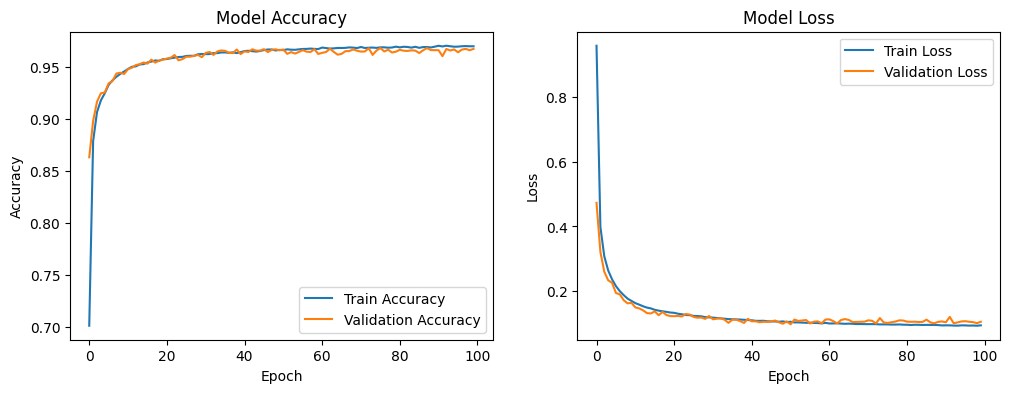

In [ ]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.show()

In [ ]:
model.save('MNIST_model.h5')